# Loading the data as a time series

In [3]:
import numpy as np
# import mne
from scipy.io import loadmat
from scipy.signal import decimate
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from eeg_utils import *
%matplotlib inline

In [37]:
mat = mat_to_dataframe("sub-0cGdk9_HoldL_MedOff_run1_LFP_Hilbert/sub_AbzsOg_HoldL_MedOn_merged_LFP_Hilbert.mat")

--- Processing file: sub_AbzsOg_HoldL_MedOn_merged_LFP_Hilbert.mat ---
Found data matrix. Key: 'selected_channels_signal', Shape: (2, 2277000)
Found labels. Key: 'target_labels'
Labels extracted: ['LFP-right-34', 'LFP-left-56']


--- DataFrame Created Successfully ---
          LFP-right-34  LFP-left-56
Time (s)                           
0.0000        0.516424    -9.728435
0.0005        2.786528   -11.274771
0.0010       -0.885938   -16.734607
0.0015       -1.626585   -18.135531
0.0020       -1.233082   -17.271396

Successfully extracted left LFP channel: 'LFP-left-56'
Successfully extracted right LFP channel: 'LFP-right-34'


In [38]:
df, left_lfp, right_lfp = mat

Time (s)
0.0000       0.516424
0.0005       2.786528
0.0010      -0.885938
0.0015      -1.626585
0.0020      -1.233082
               ...   
1138.4975   -0.335253
1138.4980   -0.672635
1138.4985   -1.298536
1138.4990   -0.053653
1138.4995    0.470035
Name: LFP-right-34, Length: 2277000, dtype: float64
Time (s)
0.0000       -9.728435
0.0005      -11.274771
0.0010      -16.734607
0.0015      -18.135531
0.0020      -17.271396
               ...    
1138.4975     8.822554
1138.4980     7.558925
1138.4985     1.981811
1138.4990     3.241877
1138.4995     3.298716
Name: LFP-left-56, Length: 2277000, dtype: float64

Plotting first 5000 samples...


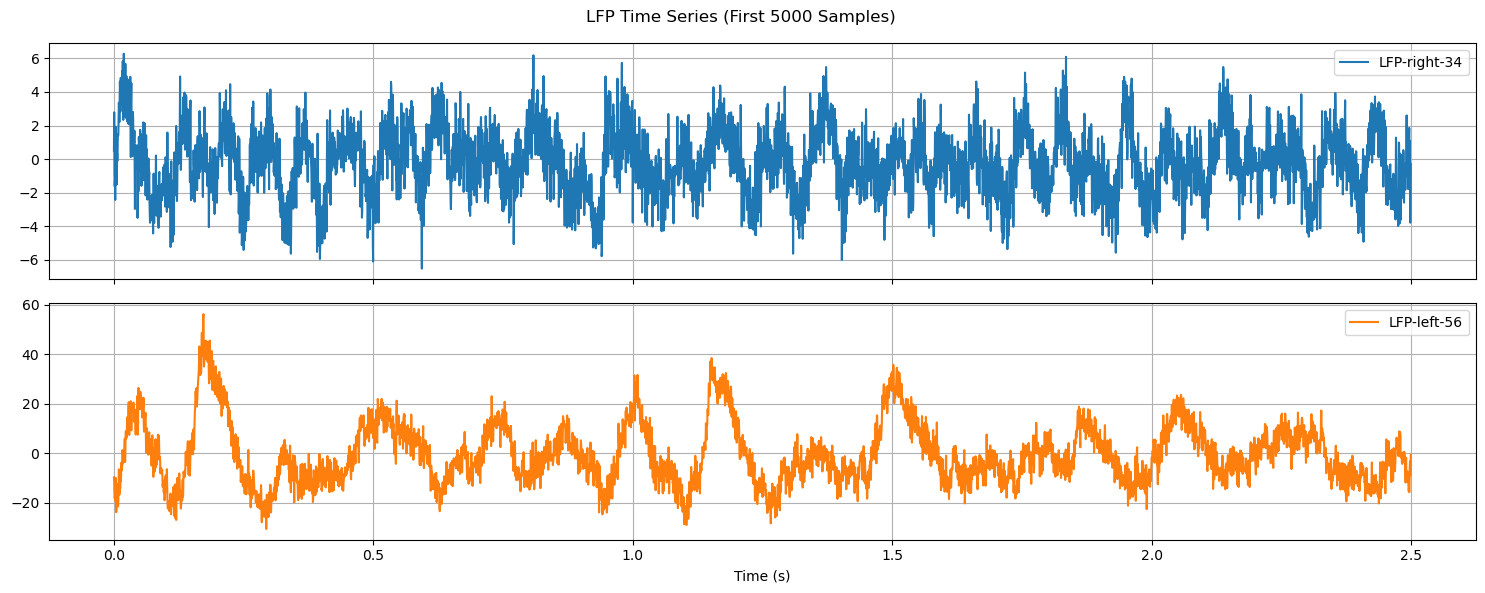

In [39]:
# You can now easily access each channel
# right_lfp = df['LFP-right-34']
# left_lfp = df['LFP-left-56']
right_lfp = df['LFP-right-34']
left_lfp = df['LFP-left-56']
print(right_lfp)
print(left_lfp)
if 'df' in locals():
    print("\nPlotting first 5000 samples...")
    plot_slice = 5000
    
    df.iloc[:plot_slice].plot(
        subplots=True,   # Plot each channel separately
        layout=(2, 1),   # Arrange in 2 rows, 1 column
        grid=True,
        title="LFP Time Series (First 5000 Samples)",
        figsize=(15, 6)  # Width, Height in inches
    )
    plt.xlabel(df.index.name)
    plt.tight_layout()
    plt.show()

In [ ]:
type(df)
print(df.head())
print(df.tail())

In [ ]:
df_dwn = downsample_eeg_dataframe(df=df,
                                  original_fs=2000,
                                  target_fs=50,
                                  plot=True)

In [ ]:
right = df_dwn['LFP-right-34']
left = df_dwn['LFP-left-56']

In [ ]:
# Slicing both time-series
left_sliced = sample_time_series_slices(left, slice_length = 2.5, n_slices = 10)
right_sliced = sample_time_series_slices(right, slice_length = 2.5, n_slices = 10)

In [ ]:
left_sliced[2].plot()

# Doing the TDA magic

In [28]:
from gtda.time_series import SingleTakensEmbedding
from gtda.time_series import TakensEmbedding
import itertools

# --- Plotting Libraries ---
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from gtda.plotting import plot_point_cloud, plot_diagram, plot_heatmap
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, PairwiseDistance, PersistenceLandscape, BettiCurve, HeatKernel, PersistenceImage, Silhouette, Scaler
import seaborn as sns


# --- Set Plotting Themes to Light Mode ---
pio.templates.default = "plotly_white" # For plotly and giotto-tda plots
plt.style.use('default') # For matplotlib plots


In [14]:
import eeg_utils
importlib.reload(eeg_utils)
from eeg_utils import *

## The current situation of the data
- Down sampled to 50 Hz
- Sliced into 10 pieces of 2.5 seconds.
- Variables are left_sliced[i] and right_sliced[i]

In [ ]:
max_embedding_dim = 10
max_time_delay = 10
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dim,
    stride=stride,
    n_jobs=-1
)

In [ ]:
left_embeddings = []
for slice in range(len(left_sliced)):
    print(f"Slice {slice + 1}:")
    left_embeddings.append(fit_embedder(embedder, left_sliced[slice]))


In [ ]:
right_embeddings = []
for slice in range(len(right_sliced)):
    print(f"Slice {slice + 1}:")
    right_embeddings.append(fit_embedder(embedder, right_sliced[slice]))

In [ ]:
plot_point_cloud(left_embeddings[5])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

In [ ]:
left_embedded_pca = pca.fit_transform(left_embedded)
plot_point_cloud(left_embedded_pca)

In [ ]:
right_embedded_pca = pca.fit_transform(right_embedded)
plot_point_cloud(right_embedded_pca)

In [ ]:
# Assuming you have your VietorisRipsPersistence object initialized
homology_dims = [0, 1, 2, 3]
persistence = VietorisRipsPersistence(homology_dimensions=homology_dims, n_jobs=-1)

# Create lists to store the diagrams for each slice
left_diagrams = []
right_diagrams = []

# --- Process Left Embeddings ---
print("--- Processing Left Channel Slices ---")
for i, embedding in enumerate(left_embeddings):
    print(f"Calculating persistence for slice {i+1}...")

    # Reshape the 2D embedding to 3D (1, n_points, n_dimensions)
    embedding_3d = embedding[None, :, :]

    # Calculate the persistence diagram
    diagram = persistence.fit_transform(embedding_3d)

    # Add the resulting diagram to our list
    left_diagrams.append(diagram)

# --- Process Right Embeddings ---
print("\n--- Processing Right Channel Slices ---")
for i, embedding in enumerate(right_embeddings):
    print(f"Calculating persistence for slice {i+1}...")

    # Reshape and transform
    embedding_3d = embedding[None, :, :]
    diagram = persistence.fit_transform(embedding_3d)

    # Add to the list
    right_diagrams.append(diagram)

In [ ]:
# Now, left_diagrams and right_diagrams are lists of persistence diagrams.
# You can inspect the first one:
print("Example of a calculated diagram's shape:")
print(left_diagrams[0].shape)

# You can then plot one of them just like before:
print("Plotting the diagram for the first slice of the left channel:")

plot_diagram(left_diagrams[3][0])

In [ ]:
# --- Create Subplot Titles ---
left_titles = [f"Left Slice {i+1}" for i in range(len(left_diagrams))]
right_titles = [f"Right Slice {i+1}" for i in range(len(right_diagrams))]

# --- Create a 4x5 Figure with Subplots ---
fig = make_subplots(
    rows=4,
    cols=5,
    subplot_titles=(left_titles + right_titles)
)

# Define colors for the different homology dimensions
dim_colors = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'purple'
}

# --- Add Traces for Left Channel Diagrams (Rows 1-2) ---
for i, diagram_3d in enumerate(left_diagrams):
    # Correctly calculate row and column for a 5-column grid
    row = (i // 5) + 1
    col = (i % 5) + 1

    diagram_2d = diagram_3d[0]

    for dim in sorted(dim_colors.keys()):
        dim_mask = diagram_2d[:, 2] == dim
        birth = diagram_2d[dim_mask, 0]
        death = diagram_2d[dim_mask, 1]
        finite_mask = np.isfinite(death)

        fig.add_trace(
            go.Scatter(
                x=birth[finite_mask],
                y=death[finite_mask],
                mode='markers',
                marker_color=dim_colors.get(dim),
                name=f'H{dim}',
                legendgroup=f'H{dim}',
                showlegend=(i == 0)  # Show legend only on the very first plot
            ),
            row=row,
            col=col
        )

    max_val = np.max(diagram_2d[np.isfinite(diagram_2d[:, 1])]) if np.any(np.isfinite(diagram_2d[:, 1])) else 1
    fig.add_shape(
        type="line", x0=0, y0=0, x1=max_val, y1=max_val,
        line=dict(color="black", width=1, dash="dash"),
        row=row, col=col
    )

# --- Add Traces for Right Channel Diagrams (Rows 3-4) ---
for i, diagram_3d in enumerate(right_diagrams):
    # Calculate row and column, starting from row 3
    row = (i // 5) + 3
    col = (i % 5) + 1

    diagram_2d = diagram_3d[0]

    for dim in sorted(dim_colors.keys()):
        dim_mask = diagram_2d[:, 2] == dim
        birth = diagram_2d[dim_mask, 0]
        death = diagram_2d[dim_mask, 1]
        finite_mask = np.isfinite(death)

        fig.add_trace(
            go.Scatter(
                x=birth[finite_mask],
                y=death[finite_mask],
                mode='markers',
                marker_color=dim_colors.get(dim),
                name=f'H{dim}',
                legendgroup=f'H{dim}',
                showlegend=False  # Hide legends for all other plots
            ),
            row=row,
            col=col
        )

    max_val = np.max(diagram_2d[np.isfinite(diagram_2d[:, 1])]) if np.any(np.isfinite(diagram_2d[:, 1])) else 1
    fig.add_shape(
        type="line", x0=0, y0=0, x1=max_val, y1=max_val,
        line=dict(color="black", width=1, dash="dash"),
        row=row, col=col
    )

# --- Update Layout and Axis Titles ---
fig.update_layout(
    height=1200,  # Increased height for 4 rows
    width=1600,
    title_text="Persistence Diagrams for All Slices",
    title_x=0.5,
    legend_title_text='Homology Dimension',
    plot_bgcolor='white'
)

fig.update_xaxes(title_text="Birth", showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(title_text="Death", showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

# Save and Load Persistence Diagrams

In [ ]:
import pickle

# Define file paths
left_diagrams_path = "left_diagrams.pkl"
right_diagrams_path = "right_diagrams.pkl"

# Save the diagrams
with open(left_diagrams_path, "wb") as f:
    pickle.dump(left_diagrams, f)
print(f"Saved left_diagrams to {left_diagrams_path}")

with open(right_diagrams_path, "wb") as f:
    pickle.dump(right_diagrams, f)
print(f"Saved right_diagrams to {right_diagrams_path}")


# Load Persistence Diagrams (run this cell if you want to load saved data)

In [7]:
import pickle

# Define file paths
left_diagrams_path = "./Saved_Data/left_diagrams.pkl"
right_diagrams_path = "./Saved_Data/right_diagrams.pkl"

# Load the diagrams
try:
    with open(left_diagrams_path, "rb") as f:
        left_diagrams = pickle.load(f)
    print(f"Loaded left_diagrams from {left_diagrams_path}")

    with open(right_diagrams_path, "rb") as f:
        right_diagrams = pickle.load(f)
    print(f"Loaded right_diagrams from {right_diagrams_path}")
except FileNotFoundError:
    print("One or both diagram files not found. Please ensure they have been saved.")


Loaded left_diagrams from ./Saved_Data/left_diagrams.pkl
Loaded right_diagrams from ./Saved_Data/right_diagrams.pkl


# Feature Extraction

## Persistence Entropy

In [ ]:
PE = PersistenceEntropy()
left_pe_features = [PE.fit_transform(slice) for slice in left_diagrams]
for feat in range(len(left_pe_features)):
    print(f"Slice {feat + 1}: {left_pe_features[feat]}")

In [ ]:
PE = PersistenceEntropy()
right_pe_features = [PE.fit_transform(slice) for slice in right_diagrams]
for feat in range(len(right_pe_features)):
    print(f"Slice {feat + 1}: {right_pe_features[feat]}")

## Other Small Features

In [ ]:
left_sm_features = [extract_features(slice, homology_dimensions=homology_dims, verbose=True) for slice in left_diagrams]

In [ ]:
right_sm_features = [extract_features(slice, homology_dimensions=homology_dims, verbose=True) for slice in right_diagrams]

## Persistence Landscapes

In [ ]:
PL = PersistenceLandscape()
left_pl = PL.fit_transform(left_diagrams[0])


In [ ]:
# Left Persistence Landscape Features
PL = PersistenceLandscape()

left_pl_features = [PL.fit_transform(slice) for slice in left_diagrams]
print(f"Shape of the PL of each slice: {left_pl_features[0].shape}")

for feat in range(len(left_pl_features)):
    print(f"Slice {feat + 1}: {left_pl_features[feat]}")


In [ ]:
PL.plot(left_pl_features[0])

In [ ]:
# Left Persistence Landscape Features
PL = PersistenceLandscape()

right_pl_features = [PL.fit_transform(slice) for slice in right_diagrams]
print(f"Shape of the PL of each slice: {right_pl_features[0].shape}")

for feat in range(len(right_pl_features)):
    print(f"Slice {feat + 1}: {right_pl_features[feat]}")


In [ ]:
PL.plot(right_pl_features[0])

## Betti Curves

In [ ]:
BC = BettiCurve()

left_bcs = [BC.fit_transform(slice) for slice in left_diagrams]

BC.plot(left_bcs[2])


In [ ]:
BC = BettiCurve()

right_bcs = [BC.fit_transform(slice) for slice in right_diagrams]

BC.plot(right_bcs[2])

## Heat Kernel

In [ ]:
HK = HeatKernel()

left_hk = HK.fit_transform(left_diagrams[0])
left_hk.shape

In [ ]:
HK.plot(left_hk)

In [ ]:
HK.plot(left_hk, homology_dimension_idx=2)

## Calculating Pairwise Distance
Here's an example of how to use `PairwiseDistance` to calculate the distance between two of your persistence diagrams.

In [32]:
# Extract all 10 diagrams (squeeze out the singleton dimension)
all_diagrams = [left_diagrams[i][0] for i in range(len(left_diagrams))]

# Pad them correctly
diagrams_array = pad_diagrams(all_diagrams)

print(f"Number of diagrams: {len(all_diagrams)}")
print(f"Padded array shape: {diagrams_array.shape}")

# Scale/normalize
scaler = Scaler(metric='wasserstein')  # or try 'landscape', 'silhouette'
diagrams_scaled = scaler.fit_transform(diagrams_array)

# Compute all pairwise distances
pwise_dist = PairwiseDistance(metric="wasserstein")
dist_mx = pwise_dist.fit_transform(diagrams_scaled)

print(f"Distance matrix shape: {dist_mx.shape}")
print(f"Distance matrix:\n{dist_mx}")

Number of diagrams: 10
Padded array shape: (10, 208, 3)
Distance matrix shape: (10, 10)
Distance matrix:
[[0.         0.45514987 0.48953996 0.24045813 0.40308402 0.63638684
  0.81642119 0.42331743 0.61832306 0.50905211]
 [0.45517209 0.         0.69411775 0.49128817 0.65701519 0.80365358
  0.96720648 0.61487104 0.81545353 0.2031588 ]
 [0.48949555 0.69418087 0.         0.44196462 0.29128376 0.31954247
  0.54194035 0.4503094  0.35519561 0.73512884]
 [0.24041537 0.4913057  0.4419416  0.         0.3483074  0.5847545
  0.79413039 0.5343368  0.6191519  0.54096993]
 [0.40312333 0.65709347 0.29124282 0.34826403 0.         0.31908856
  0.61813781 0.54106131 0.47153909 0.70140685]
 [0.63639261 0.80358449 0.31943867 0.5848019  0.31916232 0.
  0.42231321 0.6310011  0.41387794 0.84020799]
 [0.81657751 0.96724596 0.54184761 0.79416629 0.61823666 0.42239857
  0.         0.70070876 0.39760682 0.99512635]
 [0.42334766 0.61468685 0.45033713 0.53423064 0.54093264 0.63085973
  0.70068754 0.         0.44347

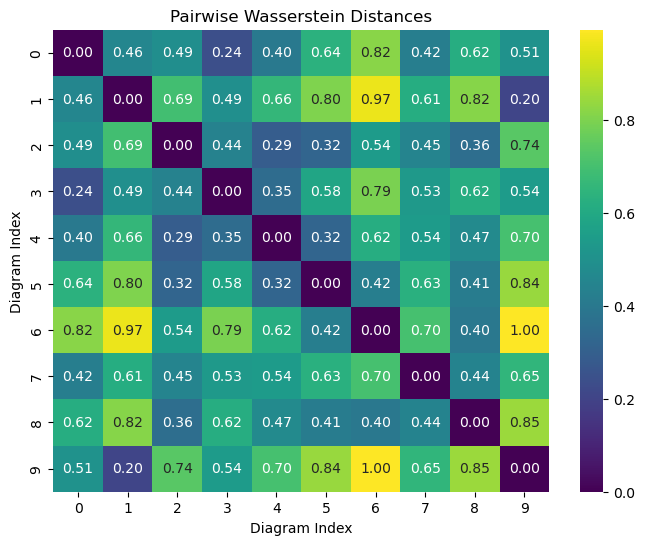

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(dist_mx, annot=True, fmt='.2f', cmap='viridis')
plt.title('Pairwise Wasserstein Distances')
plt.xlabel('Diagram Index')
plt.ylabel('Diagram Index')
plt.show()

In [34]:
# Extract all 10 diagrams (squeeze out the singleton dimension)
all_diagrams = [right_diagrams[i][0] for i in range(len(right_diagrams))]

# Pad them correctly
diagrams_array = pad_diagrams(all_diagrams)

print(f"Number of diagrams: {len(all_diagrams)}")
print(f"Padded array shape: {diagrams_array.shape}")

# Scale/normalize
scaler = Scaler(metric='wasserstein')  # or try 'landscape', 'silhouette'
diagrams_scaled = scaler.fit_transform(diagrams_array)

# Compute all pairwise distances
pwise_dist = PairwiseDistance(metric="wasserstein")
dist_mx = pwise_dist.fit_transform(diagrams_scaled)

print(f"Distance matrix shape: {dist_mx.shape}")
print(f"Distance matrix:\n{dist_mx}")

Number of diagrams: 10
Padded array shape: (10, 208, 3)
Distance matrix shape: (10, 10)
Distance matrix:
[[0.         0.56816197 0.38452912 0.3662568  0.36300803 0.45308899
  0.66242722 0.39629034 0.12897376 0.43847265]
 [0.5682381  0.         0.77413874 0.77355069 0.35375204 0.83074466
  0.38140863 0.77029185 0.51807479 0.79925525]
 [0.38450711 0.77407373 0.         0.11212614 0.58392706 0.1491718
  0.87582696 0.11777017 0.42134853 0.15665431]
 [0.36625266 0.77351088 0.11212244 0.         0.57884273 0.14691059
  0.87402755 0.14167028 0.40680652 0.13430268]
 [0.36301726 0.35378339 0.58387575 0.57890689 0.         0.64630963
  0.44577295 0.59282513 0.33664338 0.62846577]
 [0.45301572 0.8306789  0.14918885 0.14692526 0.64629726 0.
  0.92866343 0.1546086  0.49536451 0.12202145]
 [0.66244606 0.38142719 0.87588882 0.87412656 0.44586422 0.92871546
  0.         0.87843945 0.63984491 0.90932862]
 [0.39631279 0.77024054 0.11777404 0.14169754 0.5928463  0.15460791
  0.87840153 0.         0.42657

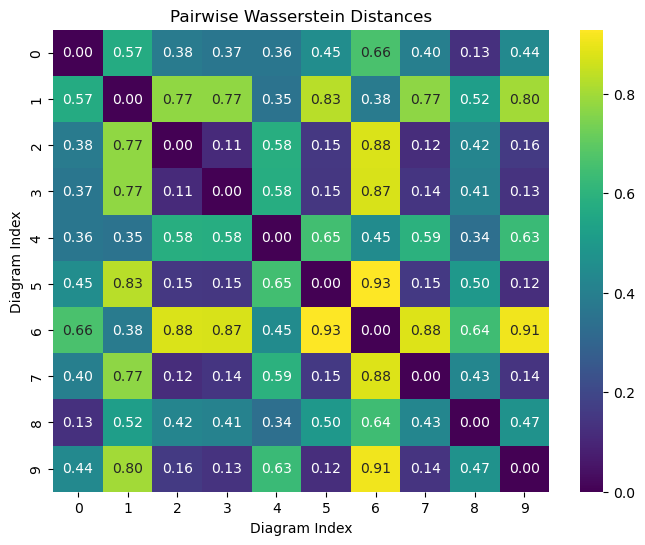

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(dist_mx, annot=True, fmt='.2f', cmap='viridis')
plt.title('Pairwise Wasserstein Distances')
plt.xlabel('Diagram Index')
plt.ylabel('Diagram Index')
plt.show()